In [134]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import cv2

In [253]:
class gabor_network(nn.Module):
    
    def __init__(self, N, m, gabor_shape = 11, output_size = 1, alpha = 0.001, iterations = 1000):
        super(gabor_network, self).__init__()
        self.fc1 = nn.Linear(gabor_shape ** 2, N)
        self.fc2 = nn.Linear(N, output_size)
        self.alpha = alpha
        self.hidden_size = N
        self.gabor_shape = gabor_shape
        self.training_size = m
        self.iterations = iterations
        
        
    def generate_gabor(self, theta):
        ksize = self.gabor_shape
        sigma = 1
        lamda = np.pi/4
        gamma = 0.1
        phi = 0
        self.gabor_size = self.gabor_shape ** 2
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
        kernel = kernel.reshape(1, self.gabor_size)
        return kernel

        
    def init_weights(self):        
        #for each angle, generate gabor filter
        #Append gabor filter to w21
        angles = np.linspace(0, np.pi, self.hidden_size)
        self.w21 = []
        for i in range(self.hidden_size):
            theta = angles[i]
            kernel = self.generate_gabor(theta)
            kernel = kernel.reshape(1, self.gabor_size)
            self.w21.append(kernel)
            
        self.w21 = torch.FloatTensor(self.w21)
        self.w21 = self.w21.T.reshape(self.hidden_size, self.gabor_size)
    
        
        self.fc1.weight = torch.nn.Parameter(self.w21.float())
        self.fc2.weight = torch.nn.Parameter(torch.zeros((1,self.hidden_size)))

    
    def input(self, angle1, angle2):
        x = np.linspace(angle1, angle2, self.training_size)
        self.labels = []
        inputs = []
        for i in range(self.training_size):
              theta = x[i]
              kernel = self.generate_gabor(theta)
              kernel = kernel.reshape(1, self.gabor_size)
              inputs.append(kernel)
              if 0 <= x[i] <= np.pi/2:
                  label = 1
              else:
                  label = -1
              self.labels.append(label)
        self.input = torch.FloatTensor(inputs)
        self.input = self.input.T.view(self.gabor_size, self.training_size)
        return self.input
        
    def desired_output(self):
        self.desired_output = self.labels
        return self.desired_output
            
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out
    
    def loss(self, scores, desired_output):
        loss = torch.linalg.norm(desired_output - scores)**2
        return loss

    def train(self, iterations, optimizer):
        self.losses = []
        for i in range(iterations):
            for j in range(self.training_size):
                optimizer.zero_grad()
                scores = self.forward(self.input[:,j])
                loss = self.loss(scores, self.desired_output[j])
                self.losses.append(loss)   
                loss.backward()
                optimizer.step()

    def mean_train(self, iterations, optimizer):
        self.losses = []
        for i in range(iterations):
            loss2 = []
            for j in range(self.training_size):
                optimizer.zero_grad()
                scores = self.forward(self.input[:,j])
                loss1 = self.loss(scores, self.desired_output[j])
                loss2.append(loss1)   
            loss = np.sum(loss2)/self.training_size
            self.losses.append(loss)
            loss.backward()
            optimizer.step()
                
    def plot_loss(self, color):
        plt.plot(self.losses, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")


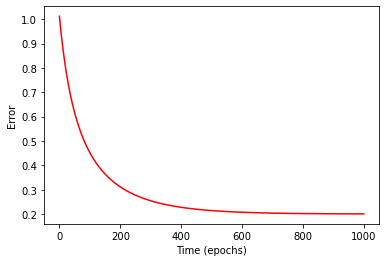

In [325]:
net = gabor_network(70, 10)
net.init_weights()
x = net.input(0, np.pi)
y = net.desired_output()
optimizer = optim.SGD(net.parameters(), lr = net.alpha)
net.mean_train(1000, optimizer)
net.plot_loss('red')

# net2 = gabor_network(500, 50)
# net2.init_weights()
# x = net2.input(-np.pi/6,np.pi/6)
# y = net2.desired_output()
# optimizer = optim.SGD(net2.parameters(), lr = net2.alpha)
# net2.mean_train(500, optimizer)
# net2.plot_loss('blue')

In [304]:
gabor = torch.tensor(net.generate_gabor(-np.pi/3)).float()
with torch.no_grad():
    a = net.forward(gabor)
    print(a)

tensor([[-0.1548]])


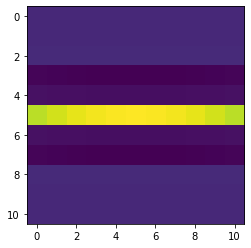

In [275]:
def generate_gabor(theta):
        ksize = 11
        sigma = 1
        lamda = np.pi/4
        gamma = 0.1
        phi = 0
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
        return kernel
b = generate_gabor(np.pi/2)
plt.imshow(b)

In [5]:
def gabor2(sigma, theta, Lambda, psi, gamma):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3  # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

In [6]:
kernel = gabor2(6, np.pi, np.pi/3, 3, 3)
# plt.imshow(kernel)
# plt.show()
kernel.shape

(37, 13)

1


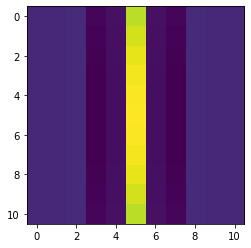

1


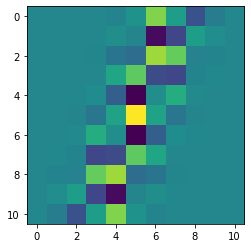

1


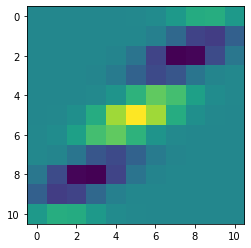

1


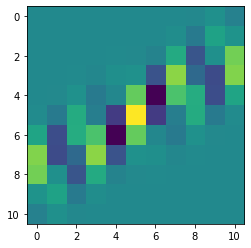

1


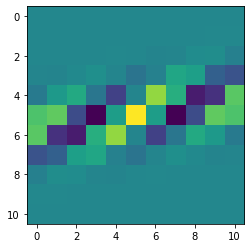

-1


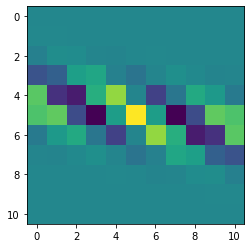

-1


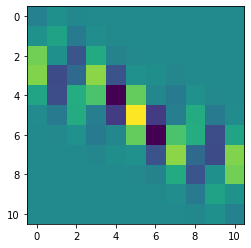

-1


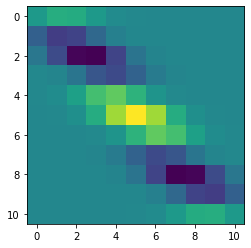

-1


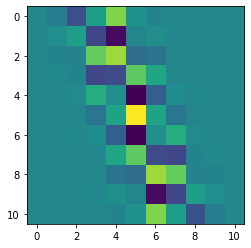

1


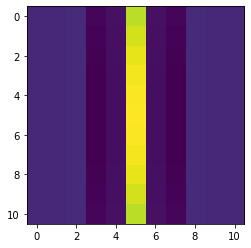

In [120]:

ksize = 11
sigma = 1
theta = 2*np.pi/3
lamda = np.pi/4
gamma = 0.1
phi = 0

x = np.linspace(0, np.pi, 10)
labels = []
for i in range(10):
    theta = x[i]
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
    if x[i] <= np.pi/2 or x[i] == np.pi:
        label = 1
    else:
        label = -1
    labels.append(label)
    plt.imshow(kernel), print(label)
    plt.show()
    



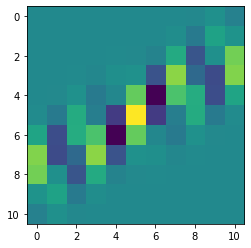

In [116]:

ksize = 11
sigma = 1
theta = np.pi/3
lamda = np.pi/4
gamma = 0.1
phi = 0
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
plt.imshow(kernel)
plt.show()


In [159]:
a = np.array(np.random.randn(100,4))
a[:][0]

array([2, 4, 6])

In [251]:
if 0<= 2 <= 4:
    print(True)

True
